# Reverend Bayes updates our Believe in Flood Detection
**How an 275 year old idea helps map the extent of floods**

![](https://upload.wikimedia.org/wikipedia/commons/d/d4/Thomas_Bayes.gif)

In [1]:
%matplotlib widget

import numpy as np
import ipywidgets as widgets
from eomaps import Maps

from tuw_education_notebooks.view_bayes_flood import view_bayes_flood
from tuw_education_notebooks.calc_bayes_flood import sig0_dc, calc_likelihoods, plot_posteriors

# From Backscattering to Flood Mapping

This notebook explains how microwave ($\sigma^0$) backscattering (Figure 1) can be used to map the extent of a flood. We replicate in this exercise the work of Bauer-Marschallinger et al. (2022) on the TUWien Bayesian-based flood mapping algorithm.

In the following lines we create a map with EOmaps (Quast 2024). You can click on the figure to see streets, cities, and other landmarks underneath the $\sigma^0$ backscattering values.

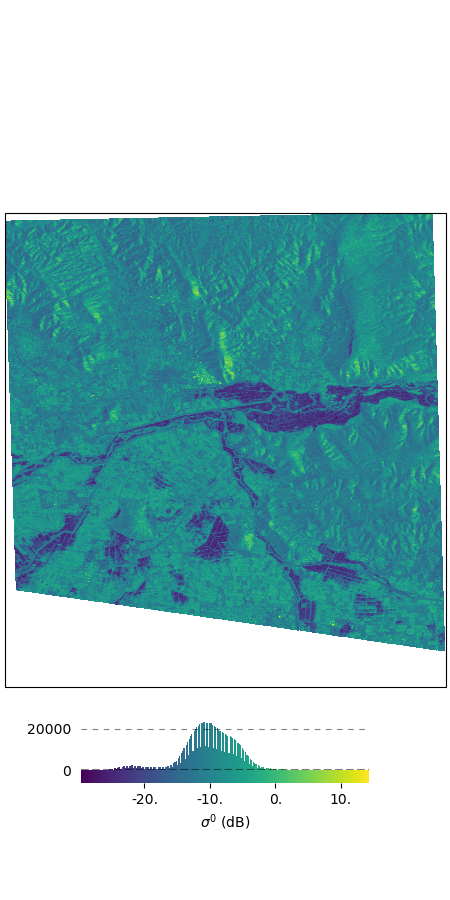

In [2]:
m = Maps(layer="data", figsize=(4.5, 9))
m.set_data(data=sig0_dc, x="x", y="y", parameter="SIG0", crs=sig0_dc.spatial_ref.crs_wkt)
m.plot_map()
m.add_colorbar(label="$\sigma^0$ (dB)", pos=(0.1, 0.1, 0.8, 0.1))
m2 = m.new_layer(layer="map")
m2.add_wms.OpenStreetMap.add_layer.default()
m.all.cb.click.attach.peek_layer(layer="data|map", how=0.5)
m.show()

*Figure 1: Area targeted for $\sigma^0$ backscattering is the Greek region of Thessaly, which experienced a major flood in February of 2018.*

## Microwave Backscattering over Land and Water

Reverend Bayes was concerned with two events, one "the hypothesis" occurring before the other "the evidence". If we know the cause it easy to logically deduce the probability of an effect. But in this case we want to deduce the probability of a cause from an observed effect, also known as "reversed probability". In the case of flood mapping we have $\sigma^0$ backscatter observations over land (effect) and we want to deduce the probability of flooding (F) and non-flooding (NF). 

Phrased differently we want to know the probability of flooding given a pixel's $\sigma^0$:

$$P(F|\sigma^0)$$

and the probability of a pixel being not flooded given a certain $\sigma^0$:

$$P(NF|\sigma^0).$$

Bayes showed that these can be deduced from the from the observation that forward and reversed probability are equal, so that:

$$P(F|\sigma^0)P(\sigma^0) = P(\sigma^0|F)P(F)$$

and

$$P(NF|\sigma^0)P(\sigma^0) = P(\sigma^0|NF)P(NF).$$


The forward probability of $\sigma^0$ given flood ($P(\sigma^0|F)$) and $\sigma^0$ given non-flood ($P(\sigma^0|NF)$) can be extracted from past information on backscattering over land and water surfaces. As seen in the figure below the characteristic of backscattering over land and water.

![Image taken from Geological Survey Ireland](https://www.gsi.ie/images/images/SAR_mapping_land_water.jpg)

*Figure 2: Schematic backscattering over land and water. Image from [Geologolgical Survey Ireland](https://www.gsi.ie/images/images/SAR_mapping_land_water.jpg)*

## Likelihoods

These so-called likelihood of $P(\sigma^0|F)$ and $P(\sigma^0|NF)$ can thus be calculated from past backscattering information.

In [3]:
pixel = widgets.IntSlider(value=0, min=0, max=sig0_dc.SIG0.size)
pixel

IntSlider(value=0, max=1209000)

Without going into the details of how these likelihoods are calculated, you can move the slider to plot the likelihoods of $\sigma^0$ being governed by land or water for each pixel in Figure 1.

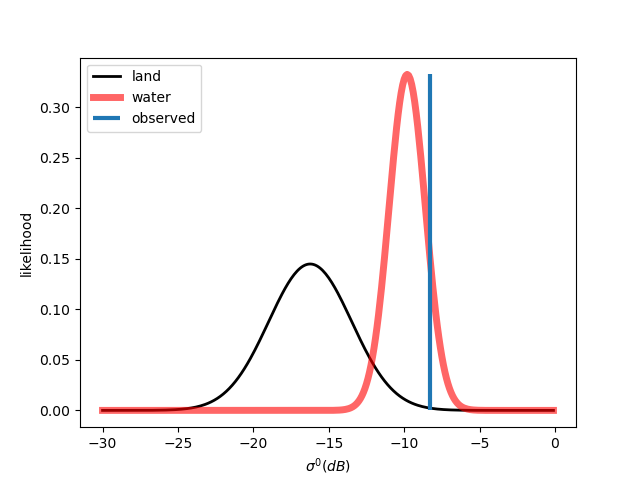

In [4]:
water_likelihood, land_likelihood = calc_likelihoods(pixel.value, x = [-30, 0], plot=True)

*Figure 3: Likelihoods for $\sigma^0$ being associated with land or water for 1 pixel in the Greek area in Thessaly (Figure 1). Likelihoods are calculated over a range of $\sigma^0$. The pixel's observed $\sigma^0$ is given with a vertical line. Move the slider and re-calculate to update this figure for another pixel in the study area.*

## Posteriors

Having calculated the likelihoods, we can now move on to calculate the probability of (non-)flooding given a pixel's $\sigma^0$. These so-called "posteriors" need on more piece of information as can be seen in the equation above. We need the probability whether a pixel is flooded $P(F)$ or non-flooded $P(NF)$. We can of course not estimate this information precisely, so our best estimate is that the chance of flooding versus non-flooding of a pixel is 50-50: a coin flip. This subjective prior believe is a fundament of Bayesian statistics and we use the likelihood to updated our believe in this particular hypothesis. We now can also calculate the probability of backscattering $P(\sigma^0)$, as the weighted average of the water and land likelihoods. The latter ensures that our updated evidence (or posteriors) ranges between 0 to 1.

The following code block show how we calculate the priors.

In [5]:
def calc_posteriors(water_likelihood, land_likelihood):
    evidence = (water_likelihood * 0.5) + (land_likelihood * 0.5)
    return (water_likelihood * 0.5) / evidence,  (land_likelihood * 0.5) / evidence

We can plot these posteriors of the probability of flooding and non-flooding again and compare these to pixel's measured $\sigma^0$ (vertical line of Figure 4).

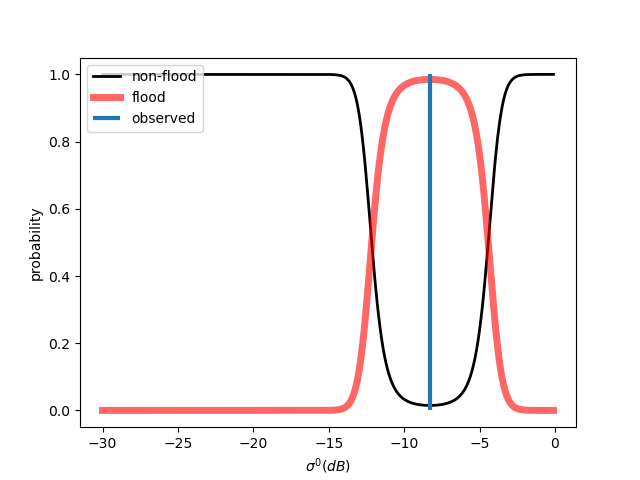

In [6]:
f_post_prob, nf_post_prob = calc_posteriors(water_likelihood, land_likelihood)
plot_posteriors(pixel.value, f_post_prob, nf_post_prob, x=[-30, 0])

*Figure 4: Posterior probabilities for $\sigma^0$ of 1 pixel being associated with land for water in the Greek area in Thessaly (Figure 1). Move the slider and re-calculate to update this figure for another pixel in the study area.*

## Flood Classification

We are now ready to combine all this information and classify the pixels according to the probability of flooding given the backscaterr value of 1 pixel. Here we just look whether the probability of flooding is higher then non-flooding:

In [7]:
def bayesian_flood_decision(id, sig0_dc):
    nf_post_prob, f_post_prob = calc_posteriors(*calc_likelihoods(id,  sig0_dc))
    return np.greater(f_post_prob, nf_post_prob)

Here we can see a single $\sigma^0$ value for the study area (Figure 1)

In [8]:
sig0 = sig0_dc.SIG0.where(sig0_dc.id==pixel.value, drop=True)
sig0

<xarray.DataArray 'SIG0' (y: 1, x: 1)> Size: 8B
array([[-8.3]])
Coordinates:
  * x        (x) float64 8B 5.661e+06
  * y        (y) float64 8B 6.42e+05
Attributes: (12/30)
    abs_orbit_number:       20802
    AREA_OR_POINT:          Area
    border_noise_removed:   True
    creation_date:          2021-07-19 19:54:09
    creator:                gfm_ops
    dem_source:             /eodc/private/jrc_gfm/gfm_scratch/copdem/CopDEM30...
    ...                     ...
    worker_git_tag:         from v1.0.0 to v1.1.0
    worker_name:            s1-sigma
    wrapper_git_commit:     none
    wrapper_git_tag:        v1.0.0
    wrapper_name:           gfm-sigma-offline
    grid_mapping:           spatial_ref

We can then inject this in the function for flood mapping, as follows:

In [9]:
bayesian_flood_decision(pixel.value, sig0)

array([ True])

Now we do the same for the whole study area. **Click** on a point in the below map to see the likelihoods and posterior distributions (in the left-hand subplots).

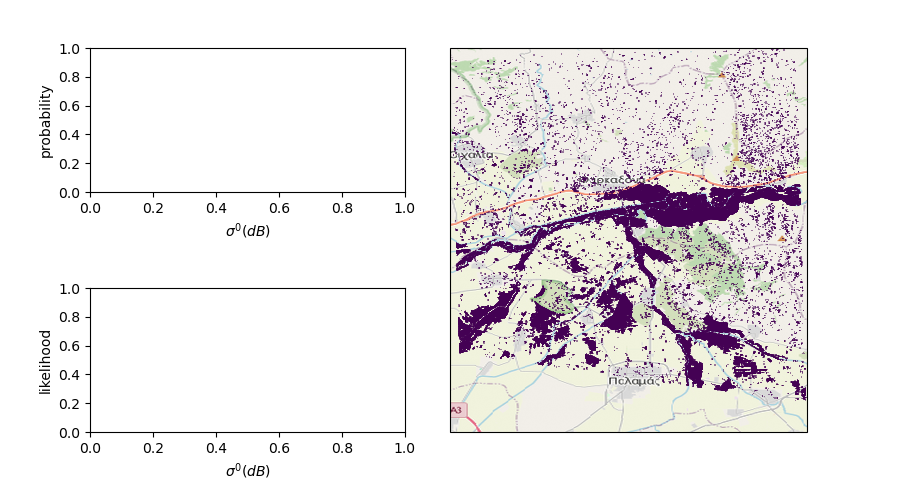

In [10]:
view_bayes_flood(sig0_dc, calc_posteriors, bayesian_flood_decision)

*Figure 5: Flood extent of the Greek region of Thessaly based on Bayesian probabilities are shown on the map superimposed on an open street map. Click on a pixel to generate the point's water and land likelihoods as well as the posterior probabilities. Map created with EOmaps (Quast 2024)*

## References

Bauer-Marschallinger, Bernhard, Senmao Cao, Mark Edwin Tupas, Florian Roth, Claudio Navacchi, Thomas Melzer, Vahid Freeman, and Wolfgang Wagner. 2022. “Satellite-Based Flood Mapping Through Bayesian Inference from a Sentinel-1 SAR Datacube.” Remote Sensing 14 (15): 3673. [https://doi.org/10.3390/rs14153673](https://doi.org/10.3390/rs14153673)

Quast Raphael. 2024. "EOmaps" [Computer software]. [https://eomaps.readthedocs.io/en/latest/index.html](https://eomaps.readthedocs.io/en/latest/index.html)